### Assignment 4
Use the same setup and the same split of the data as we did in Module 2.\
Fit a Classification Tree to the data set, do some mild tuning. \
Determine the confusion matrix for a 50% threshold for the test set. \
Produce an ROC curve using the test set for your classifier. What is the AUCs? \
Compare the results to the classifiers we used in Module 2

#### Import related modules and data
We first import the Wine data and split it the same way as in WineData notebook. Since we want to get the prediction for "quality", we convert it to Ture or False value by setting the threshold of 6. Quality > 6 will be considered as True which means high quality.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from io import StringIO
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.metrics import confusion_matrix, classification_report, precision_score, roc_curve, auc

In [ ]:
!git clone https://github.com/danielbauer1979/ML_656.git

Cloning into 'ML_656'...
remote: Enumerating objects: 299, done.
remote: Counting objects: 100% (182/182), done.
remote: Compressing objects: 100% (106/106), done.
remote: Total 299 (delta 106), reused 123 (delta 76), pack-reused 117
Receiving objects: 100% (299/299), 24.12 MiB | 14.90 MiB/s, done.
Resolving deltas: 100% (156/156), done.


In [ ]:
wine = pd.read_csv('ML_656/winequality-red.csv', sep = ';')
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [ ]:
import pydot
from IPython.display import Image
def print_tree(estimator, features, class_names=None, filled=True):
    tree = estimator
    names = features
    color = filled
    classn = class_names
    dot_data = StringIO()
    export_graphviz(estimator, out_file=dot_data, feature_names=features, class_names=classn, filled=filled)
    graph = pydot.graph_from_dot_data(dot_data.getvalue())
    return(graph)

In [ ]:
wine['quality'] = wine['quality'] > 6
wine['quality'].describe()

count      1599
unique        2
top       False
freq       1382
Name: quality, dtype: object

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(wine.drop(columns=['quality']), \
                                                    wine['quality'], test_size=0.3, random_state=43)


We have set the data with exactly the same as we did in assignment2. Next we will fit the data to a classification tree. We try to apply for different steps and see how does the complexity of the trees would impact the prediction.


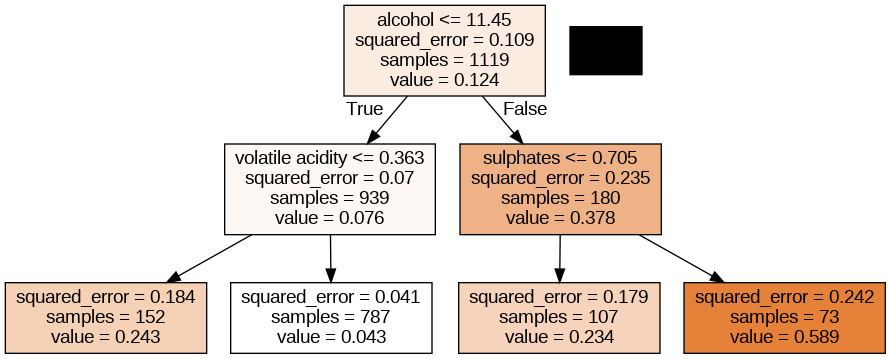

In [ ]:
Wine_tree_first = DecisionTreeRegressor(max_leaf_nodes=4)
Wine_tree_first.fit(X_train, y_train)
graph, = print_tree(Wine_tree_first, features=X_train.columns)
Image(graph.create_png())

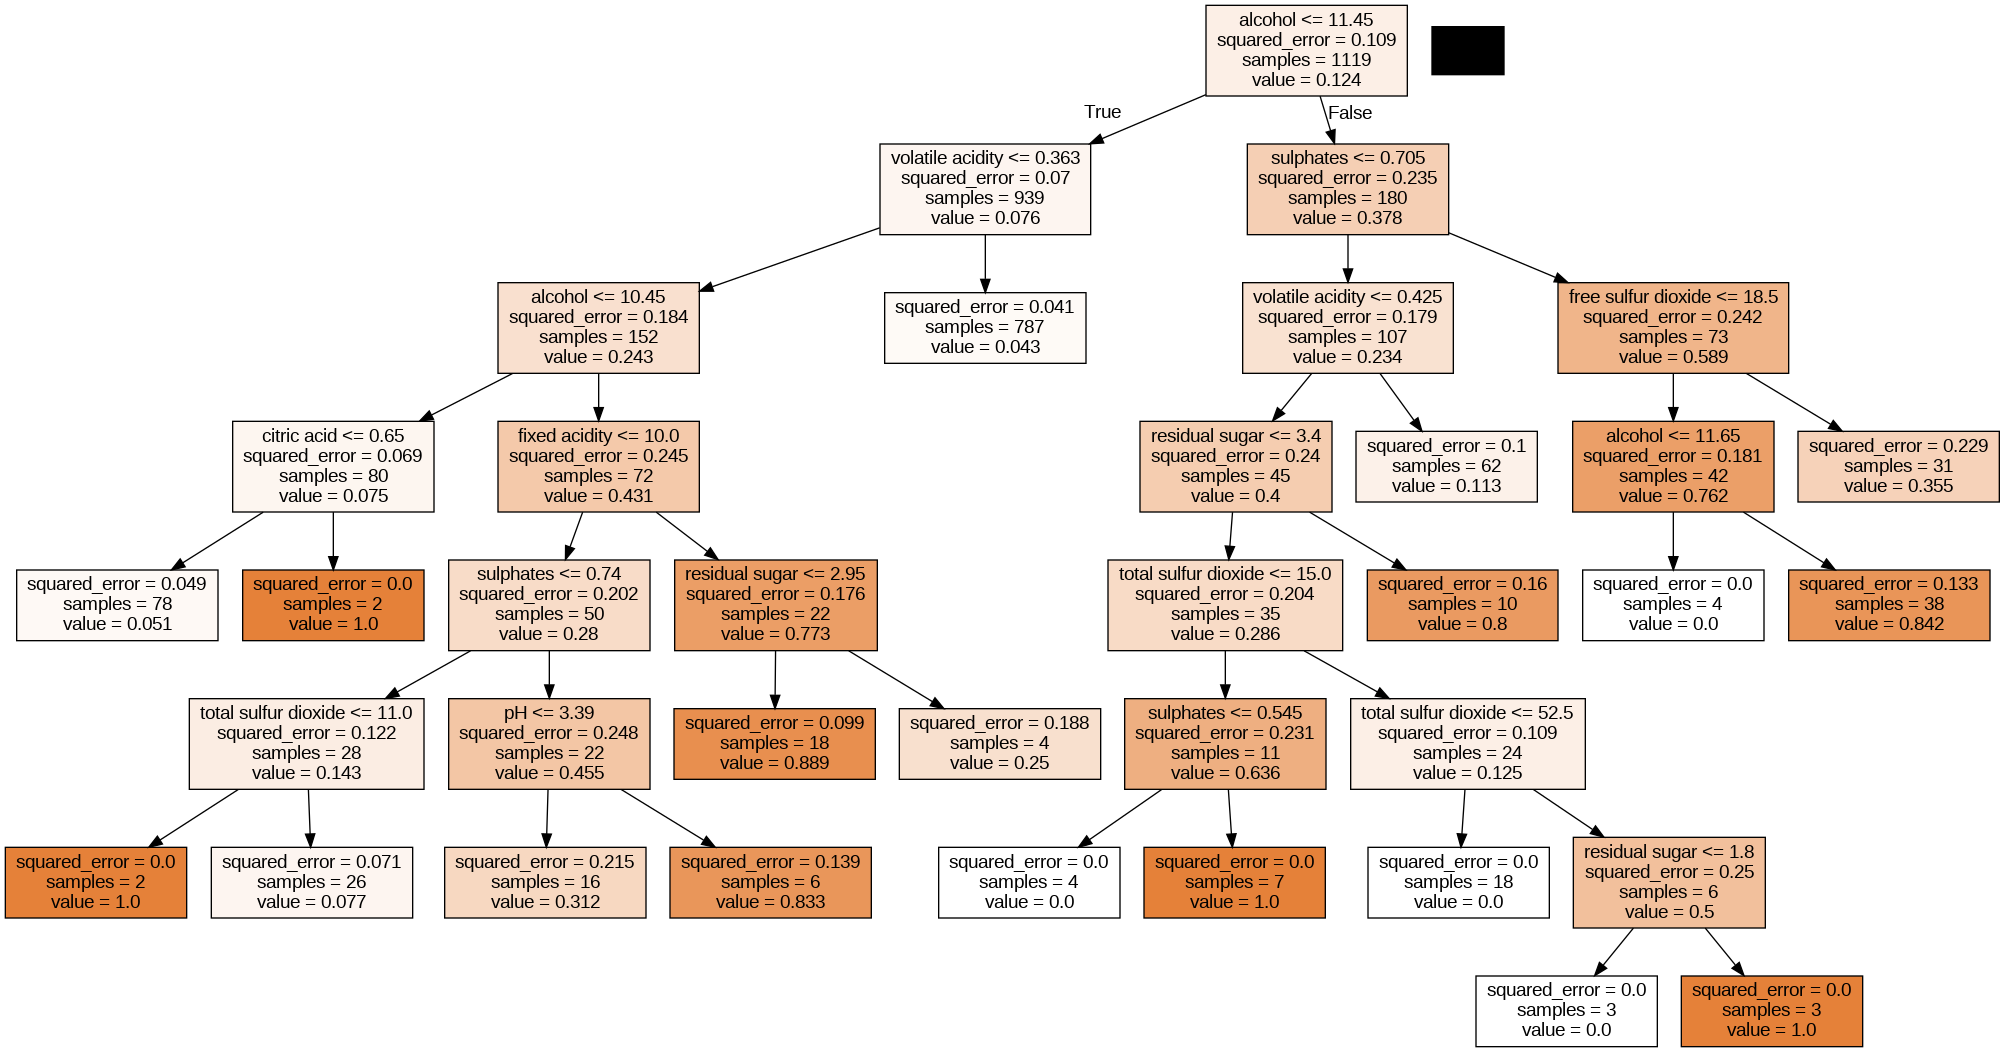

In [ ]:
Wine_tree = DecisionTreeRegressor(min_samples_split=5,min_impurity_decrease=0.001)
Wine_tree.fit(X_train, y_train)
graph, = print_tree(Wine_tree, features=X_train.columns)
Image(graph.create_png())

In [ ]:
summary_tree = pd.DataFrame({'Features':X_train.columns,'Importance':Wine_tree.feature_importances_})
summary_tree.sort_values(by=['Importance'], ascending=False)

,Features,Importance
10,alcohol,0.372301
9,sulphates,0.162372
1,volatile acidity,0.127741
3,residual sugar,0.086139
6,total sulfur dioxide,0.082386
0,fixed acidity,0.065297
5,free sulfur dioxide,0.052028
2,citric acid,0.030898
8,pH,0.020839
4,chlorides,0.000000


In [ ]:
Wine_tree.tree_.node_count

37

#### Apply 50% threshold confusion matrix for the test set.
Next, we apply a 50% threshold to generate the confusion matrix. We can find the classification tree model is good at the true false prediction.

In [ ]:
yhat = Wine_tree.predict(X_test)
pred = yhat > 0.5
np.sum(pred)

63

In [ ]:
table = pd.DataFrame({'quality':y_test,'pred':pred})
table.groupby(['quality','pred']).size().unstack('quality')

quality,False,True
pred,,
False,379,38
True,23,40


#### Determine the ROC curve
Finally, we plot the ROC curves. We can find the AUC is euqal to 0.81 here, which is a relatively good performance.

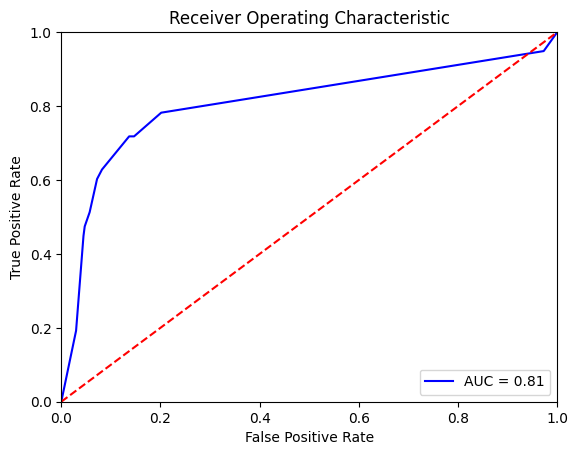

In [ ]:
fpr, tpr, threshold = roc_curve(y_test, yhat)
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### Compare to results from logistic regression
We fit the same data to the logistic regression, and also apply the same threshold confusion matrix. We can find both models are having similar performance in the confusion matrix. However, when we apply the ROC curve to the logistic regression, we can find the AUC is 0.90. It indicates the logistic regression is perform better than the classification tree model here for the wine data. Therefore, to predict more accurate high quality wine, we should apply logistic regression model here.

In [ ]:
logistic_model = LogisticRegression(fit_intercept=True, max_iter=1000).fit(X_train,y_train)
print(logistic_model.intercept_)
print(logistic_model.coef_)

[-12.2142169]
[[ 0.11369242 -2.17628648  0.23543498  0.10571468 -0.78742682  0.00988878
  -0.01398038 -0.01483354 -0.3561782   2.05754862  0.94916508]]


In [ ]:
logistic_pred_test = logistic_model.predict_proba(X_test)
np.sum(logistic_pred_test[:,1] > 0.5)

31

In [ ]:
logistic_pred_test_lab = logistic_pred_test[:,1] > 0.5
confusion_matrix(y_test, logistic_pred_test_lab)

array([[392,  10],
       [ 57,  21]])

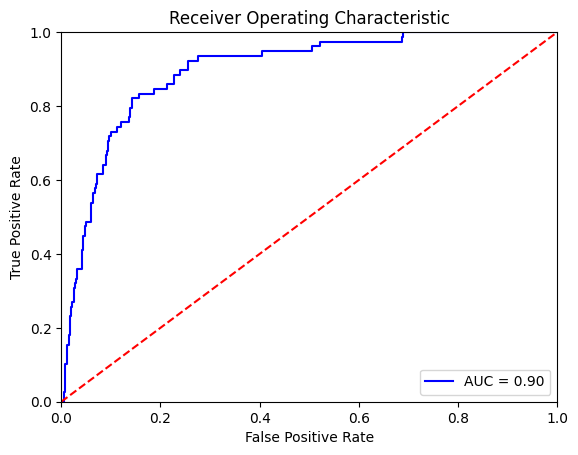

In [ ]:
fpr, tpr, threshold = roc_curve(y_test, logistic_pred_test[:,1])
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()